In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

In [117]:
STARTING_DAY = datetime.datetime(1989, 1, 1)
FIRST_ACTION_DAY = datetime.datetime(1994, 1, 1)

In [118]:
ew_weights = pd.read_csv('data/ew_weights.csv', index_col=0)
min_variance_weights = pd.read_csv('data/min_variance_weights.csv', index_col=0)
ew_weights.index = pd.to_datetime(ew_weights.index)
min_variance_weights.index = pd.to_datetime(min_variance_weights.index)

In [119]:
selected_stocks = pd.read_excel('data/selected_stocks.xlsx')

# Download prices
symbols = selected_stocks['Symbol'].tolist()
prices = yf.download(symbols)

# Exclude data before STARTING DAY
prices = prices.loc[STARTING_DAY:]

# Separate variables
adj_close_df = prices['Adj Close']
close_df = prices['Close']
open_df = prices['Open']

adj_close_returns = utils.compute_returns(adj_close_df)
close_returns = utils.compute_returns(close_df)
open_returns = utils.compute_returns(open_df)

[*********************100%%**********************]  11 of 11 completed


In [120]:
action_days = ew_weights.index

In [121]:
ew_strategy_returns = []
min_variance_strategy_returns = []
for i in range(len(action_days) - 1):
    start = action_days[i]
    end = action_days[i+1] - datetime.timedelta(days=1)  # End is included
    stocks_returns_in_period = adj_close_returns.loc[start:end]
    w_ew = ew_weights.loc[start]
    w_min_var = min_variance_weights.loc[start]
    ew_strategy_returns.append(
        utils.compute_single_period_returns(stocks_returns_in_period, w_ew).sum(axis=1).iloc[-1] - 1)
    min_variance_strategy_returns.append(
        utils.compute_single_period_returns(stocks_returns_in_period, w_min_var).sum(axis=1).iloc[-1] - 1)

In [122]:
df_strategy = pd.DataFrame(
    {
        'ew_strategy': ew_strategy_returns,
        'min_variance_strategy': min_variance_strategy_returns
    },
    index=action_days[1:])

In [123]:
df_strategy

,ew_strategy,min_variance_strategy
1994-02-01,0.031101,-0.010283
1994-03-01,0.005586,-0.026627
1994-04-04,-0.060629,-0.040420
1994-05-02,0.002861,0.047834
1994-06-01,0.011740,-0.032938
...,...,...
2024-03-01,0.060356,0.057865
2024-04-01,0.053396,0.049048
2024-05-01,-0.020908,-0.011312
2024-06-03,0.050253,0.080479


In [124]:
df_strategy_cumret = (df_strategy + 1).cumprod() - 1

In [125]:
plt.style.use('ggplot')
colors = sns.color_palette('Paired', 4)

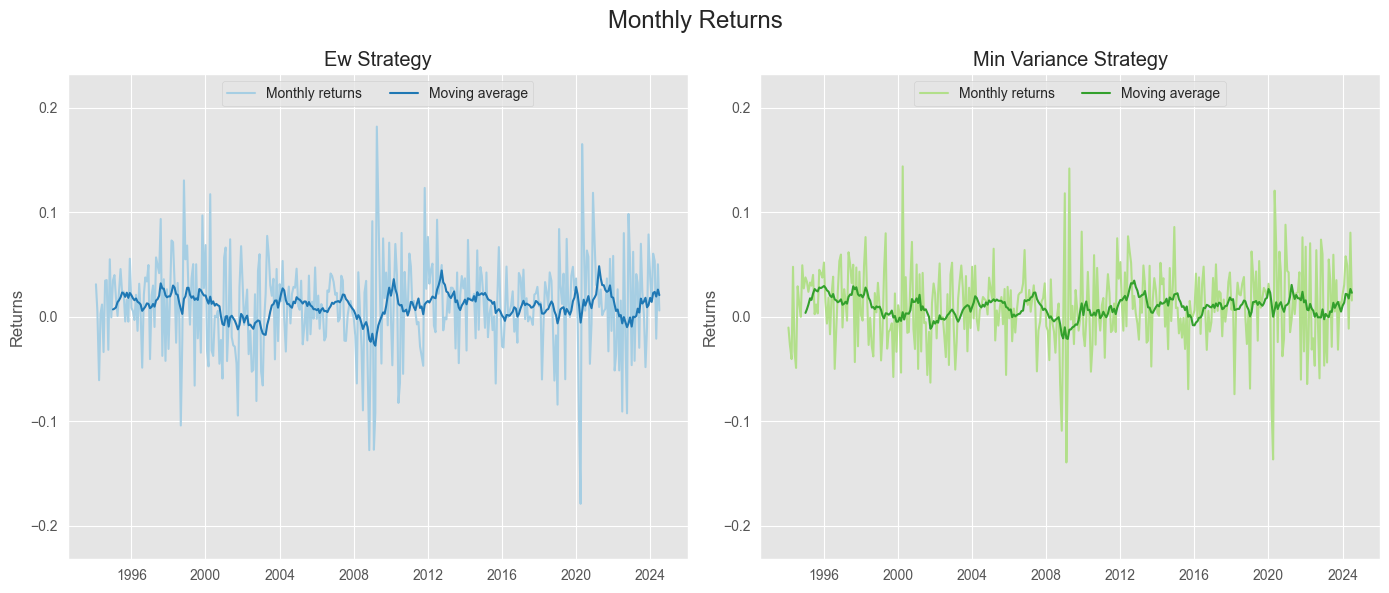

In [186]:
fig1, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
limit = np.max(np.abs(df_strategy.values)).item()
delta = 0.05
rolling_window = 12
for i in range(len(df_strategy.columns)):
    # Plot monthly returns
    axes[i].plot(df_strategy.iloc[:, i], label=f'Monthly returns', color=colors[i*2])
    # Set same scale
    axes[i].set_ylim((-(limit + delta), limit + delta))
    # Plot moving average
    axes[i].plot(df_strategy.iloc[:, i].rolling(rolling_window).mean(), label=f'Moving average', color=colors[i*2 + 1])
    axes[i].legend(ncol=2, loc='upper center')
    axes[i].set_title(f'{df_strategy.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    axes[i].set_ylabel('Returns')
fig1.suptitle(f'Monthly Returns', fontsize='xx-large')
plt.show()

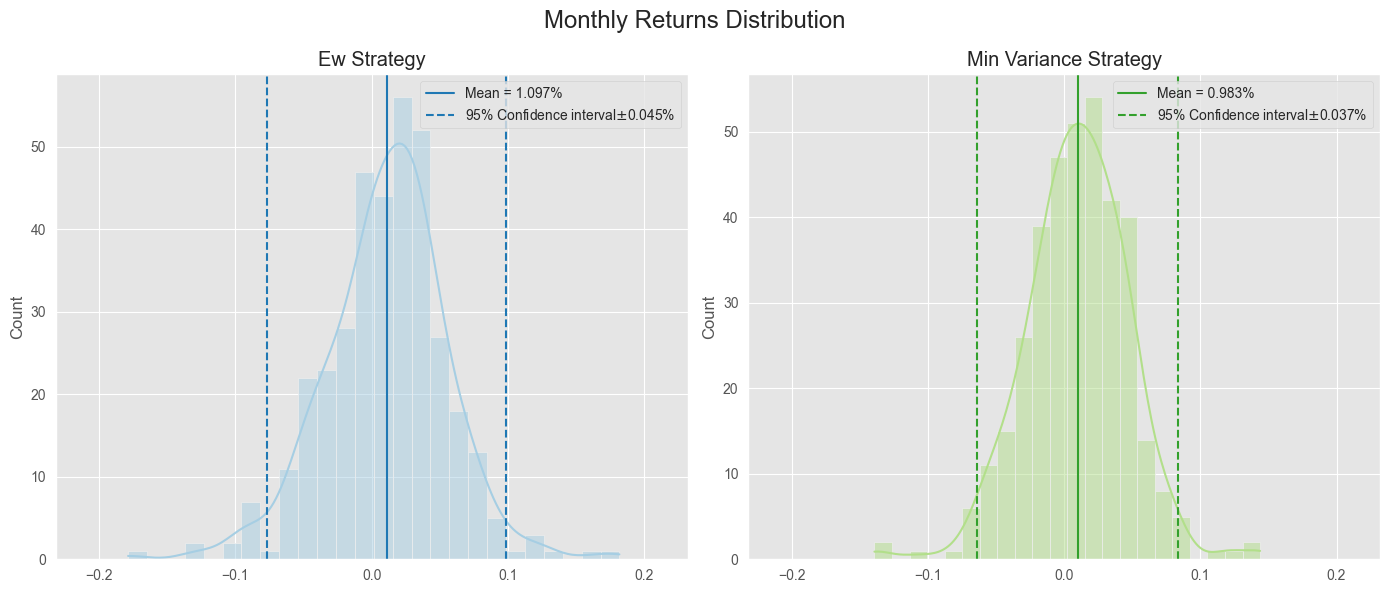

In [187]:
fig2, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for i in range(len(df_strategy.columns)):
    sns.histplot(df_strategy.iloc[:, i], ax=axes[i], color=colors[i*2], kde=True)
    axes[i].set_xlim((-(limit + delta), limit + delta))
    axes[i].set_xlabel('')
    axes[i].set_title(f'{df_strategy.columns[i]}'.replace('_', ' ').title(), fontsize='x-large')
    mu = df_strategy.iloc[:, i].mean()
    sd = df_strategy.iloc[:, i].std()
    ci = ((mu - 1.96*sd).item(), (mu + 1.96*sd).item())
    axes[i].axvline(mu, label=f'Mean = {100*mu:.3f}%', color=colors[i*2 + 1])
    axes[i].axvline(ci[0], label=f'95% Confidence interval' + r'$\pm$' + f'{np.round(sd, 3)}%', color=colors[i*2 + 1], ls='--')
    axes[i].axvline(ci[1], color=colors[i*2 + 1], ls='--')

    axes[i].legend()
fig2.suptitle(f'Monthly Returns Distribution', fontsize='xx-large')
plt.show()

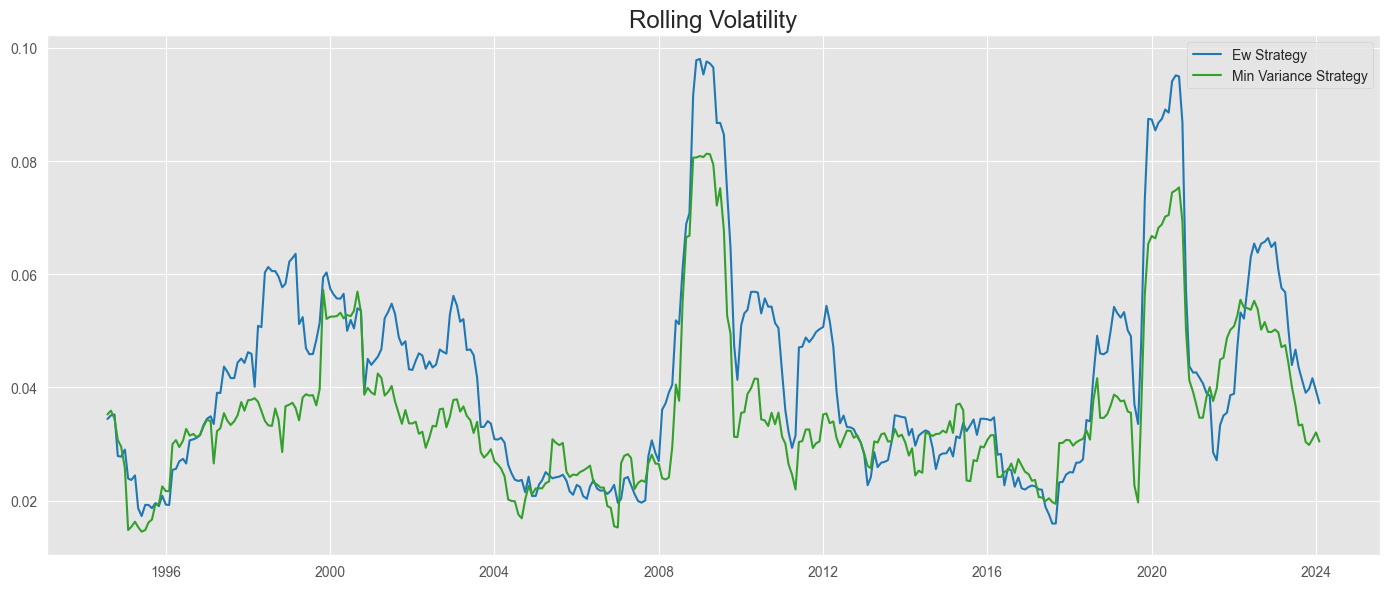

In [190]:
fig3, ax = plt.subplots(figsize=(14, 6), tight_layout=True)
for i in range(len(df_strategy.columns)):
    ax.plot(df_strategy.iloc[:, i].rolling(rolling_window, center=True).std(),
            label=f'{df_strategy.columns[i].replace("_", " ").title()}', color=colors[i*2 +1])
ax.legend()
ax.set_title(f'Rolling Volatility', fontsize='xx-large')
plt.show()